# Data Ingestion – Tabular Formats

_Tidy datasets are all alike, but every messy dataset is messy in its own way._

Hadley Wickham (cf. Leo Tolstoy)

A great deal of data both does and should live in tabular formats; to put it flatly, this means formats that have rows and columns.  In a theoretical sense, it is possible to represent *every* collection of *structured data* in terms of multiple "flat" or "tabular" collections if we also have a concept of *relations*.  Relational database management systems (RDBMS) have had a great deal of success since 1970, and a very large part of all the world's data lives in RDBMS's.  Another large share lives in formats that are not relational as such, but that are nonetheless tabular, wherein relationships may be *imputed* in an ad hoc, but uncumbersome, way.

This lesson discusses tabular formats including CSV, spreadsheets, and SQL databases.  *Remediating* characteristic problems is largely left until later chapters; detecting them is this lesson's focus of attention.  A variety of libraries and data sets are loaded prior to the code slides that follow.

In [1]:
from src.setup import *

Raw data often starts out in an untidy formats; happily for the below example, our data is at least straightforwardly readable.

In [2]:
# Tidying up
students = pl.read_csv("data/students-scores.csv")
students

Last Name,First Name,4th Grade,5th Grade,6th Grade
str,str,str,str,str
"""Johnson""","""Mia""","""A""","""B+""","""A-"""
"""Lopez""","""Liam""","""B""","""B""","""A+"""
"""Lee""","""Isabella""","""C""","""C-""","""B-"""
"""Fisher""","""Mason""","""B""","""B-""","""C+"""
"""Gupta""","""Olivia""","""B""","""A+""","""A"""
"""Robinson""","""Sophia""","""A+""","""B-""","""A"""


Tidy data carefully separates variables (the columns of a table; also called features or fields) from observations (the rows of a table; also called samples).  At the intersection of these two, we find values, one data item in each cell.  Unfortunately, the data we encounter is often not arranged in this useful way, and it requires *normalization*.  In particular, what are really values are often represented either as columns or as rows instead. 

In this example of a small elementary school class we encounter data that is simple but untidy.  In particular, the sequence of different years the same student progresses through are represented as columns rather than by rows.

In [3]:
# Massage the DataFrame
to_num = {'A+': 4.3, 'A': 4, 'A-': 3.7, 
          'B+': 3.3, 'B': 3, 'B-': 2.7, 
          'C+': 2.3, 'C': 2, 'C-': 1.7}
df = (students.with_columns(
    pl.col("4th Grade").replace(to_num, default=None),
    pl.col("5th Grade").replace(to_num, default=None),
    pl.col("6th Grade").replace(to_num, default=None)
)
    .drop(["First Name", "Last Name"])
    .transpose(include_header=False,
               column_names=students["Last Name"])
)
df

Johnson,Lopez,Lee,Fisher,Gupta,Robinson
f64,f64,f64,f64,f64,f64
4.0,3.0,2.0,3.0,3.0,4.3
3.3,3.0,1.7,2.7,4.3,2.7
3.7,4.3,2.7,2.3,4.0,4.0


While tidyness is partially determined by purpose, we here wish to focus on the sequence of scores each student receives in successive years.  If we later obtain data on each students performance in 3rd or 7th grade, that would fit naturally within our transformed format.

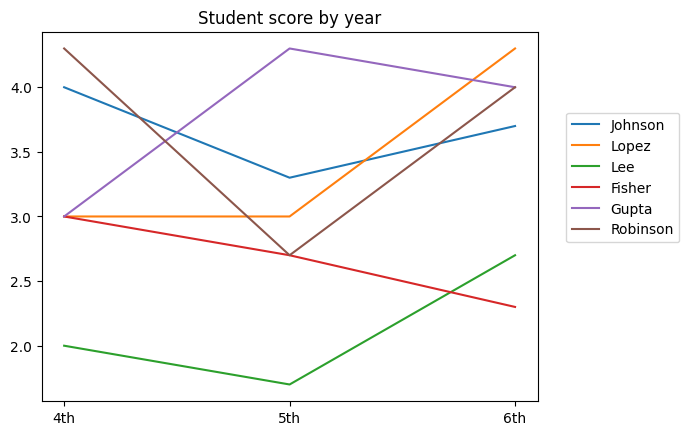

In [4]:
for student in students["Last Name"]:
    plt.plot(["4th", "5th", "6th"], df[student], label=student)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, .80));
plt.title("Student score by year");

The particular class level that a letter grade applies to is an independent variable rather than a dependent variable.  In machine learning terms, this corresponds to features versus target.  The class level might influence a resulting letter grade, but the letter grade does not generally predict or cause the class level.

## CSV

Delimited text files, especially comma-separated-value files, are ubiquitous.  These contain multiple values on each line, and separate those values with some semi-reserved character, such as a comma.  Delimited files are commonly used to transport data between other tabular representations

Reading delimited files is not the fastest way of reading data from disk into RAM memory, but it is also not the slowest.  Of course, that concern only matters for large-ish data sets, not for the small data sets that make up most of our work as data scientists (small nowadays means roughly "fewer then 100k rows").

There are a great number of deficits in CSV files, but also some notable strengths.  CSV files are the format second most susceptible to structural problems.  All formats are generally equally prone to content problems, which are not tied to the format itself.  Spreadsheets like Excel are, of course, *by a very large margin* the worst format for every kind of data integrity concern.

At the same time, delimited formats—or fixed-width text formats—are also almost the only ones you can easily open and make sense of in a text editor or easily manipulate using command-line tools for text processing.  Thereby delimited files are pretty much the only ones you can fix fully manually without specialized readers and libraries.  Of course, formats that rigorously enforce structural constraints *do avoid some* of the need to do this.  Later in this chapter, and in the next two chapters, a number of formats that enforce structure more are discussed.

One issue that you could encounter in reading CSV or other textual files is the actual character set encoding may not be the one you expect, or that is the default on your current system.  In this age of Unicode, this concern is diminishing, but only slowly, and archival files continue to exist.  This topic is discussed in chapter 3 (*Data Ingestion – Repurposing Data Sources*) in the section *Custom Text Formats*.

### Sanity Checks

Suppose you have just received a medium sized CSV file, and you want to make a quick sanity check on it. At this stage, you are concerned about whether the file is formatted correctly at all.  We can try to read the file using, for example, Pandas and Polars, and we see fairly helpful errors.

In [15]:
# Use try/except to avoid full traceback in example
try:
    pd.read_csv('data/big-random.csv')
except Exception as err:
    print_err(err)

ParserError
Error tokenizing data. C error: Expected 6 fields in line 75, saw 8


In [78]:
try:
    pl.read_csv('data/big-random.csv')
except Exception as err:
    print_err(err)

ComputeError
found more fields than defined in 'Schema'  Consider setting
'truncate_ragged_lines=True'.


What went wrong there? Let us check.

In [13]:
%%bash
# What is the general size/shape of this file?
wc data/big-random.csv

 100000  100000 4335846 data/big-random.csv


Great! 100,000 rows; but there is some sort of problem on line 75 according to Pandas (and perhaps on other lines as well). Using a single piped bash command which counts commas per line might provide insight.  We could perform this same analysis in Python, R, or other languages; however, being familiar with command-line tools is a benefit to data scientists in performing one-off analyses like this.

In [21]:
%%bash
cat data/big-random.csv | 
    tr -d -c ',\n' |          # remove everything not comma or newline
    awk '{ print length; }' | # print the length of trimmed line
    sort |                    # sort all those lengths  
    uniq -c                   # histogram of lengths

     46 3
  99909 5
     45 7


So we have figured out already that 99,909 of the lines have the expected 5 commas.  But 46 lines have a deficit and 45 a surplus.  Perhaps we should discard the bad lines, but maybe we can fix them by hand in a text editor.  This is a task-driven decision to make.

Let us take a look at a few of the problem rows.  These are some rows with 7 commas and the lines before and after each.

In [24]:
%%bash
grep -C1 -nP '^([^,]+,){7}' data/big-random.csv | head -11

74-squarcerai,45,quiescenze,12,scuoieremo,70
75:fantasmagorici,28,immischiavate,44,schiavizzammo,97,sfilzarono,49
76-interagiste,50,repentagli,72,attendato,95
--
712-resettando,58,strisciato,46,insaldai,62
713:aspirasse,15,imbozzimatrici,70,incanalante,93,succhieremo,41
714-saccarometriche,18,stremaste,12,hindi,19
--
8096-squincio,16,biascicona,93,solisti,70
8097:rinegoziante,50,circoncidiamo,83,stringavate,79,stipularono,34
8098-disaeriamo,94,sfiorisce,37,mesterebbe,46


Looking at these lists of Italian words and integers with varying number of fields does not immediately illuminate the nature of the problem.  We likely need more domain knowledge.  However, given that fewer than 1% of rows are a problem, perhaps we should simply discard them for now.  

If you do decide to make a modification such as removing rows, then versioning the data, with accompanying documentation of change history and reasons, becomes crucial to good data and process provenance.

In [32]:
import io
buff = io.StringIO() 
for line in open('data/big-random.csv'):
    if line.count(",") == 5:
        buff.write(line)
buff.seek(0)            
pl.read_csv(buff, has_header=False)

column_1,column_2,column_3,column_4,column_5,column_6
str,i64,str,i64,str,i64
"""infilaste""",21,"""esemplava""",15,"""stabaccavo""",73
"""abbadaste""",50,"""enartrosi""",85,"""iella""",54
"""frustulo""",77,"""temporale""",83,"""scoppianti""",91
"""gavocciolo""",84,"""postelegrafiche""",93,"""inglesizzanti""",63
"""svani""",92,"""spiombasti""",99,"""aderisce""",74
…,…,…,…,…,…
"""rattralciassi""",12,"""riflessogeni""",65,"""rinvanghiate""",90
"""notareschi""",60,"""paganico""",64,"""esecutavamo""",20
"""rispranghiamo""",11,"""schioccano""",44,"""imbozzarono""",80


In the example pure-Python manipulation is used to create an in-memory CSV file.  Pandas has the parameter `error_bad_lines` to achieve a similar effect, and Polars offers `truncate_ragged_lines`. Other dataframe libraries have analogous cleanup mechanisms. For this illustration, the Python loop is more explicit.

### The Good, The Bad, and The Textual Data

Textual data files have advantages and disadvantages. Delimited files use a *delimiter*, as the name suggests, while fixed width files use specific offsets. Let's discuss some advantages and disadvantages.

Text files that store tabular data usually use a single character for a delimiter, and end rows/records with a newline (or carriage return and newline in legacy formats).  Other than commas, probably the most common delimiters you will encounter are tabs and the pipe character `|`.

Fixed-width files are similar to delimited ones.  Technically they are different in that, although they are line oriented, they put each field of data in specific character positions within each line. Decades ago, when Fortran and Cobol were more popular, fixed-width formats were more prevalent but their use has diminished in favor of delimited files.  Fixed-width textual data files have most of the same pitfalls and strengths as do delimited ones.

**The Bad**

Columns in delimited or flat files do not carry a data type, being simply text values.  Many tools will (optionally) make guesses about the data type, but these are subject to pitfalls.  Even where the tools accurately guess the broad type category they cannot guess the specific bit lengths desired.

The representation used for "real" numbers is not encoded in textual data files. Most systems treat decimal values as IEEE-754 floating-point numbers of some length, but occasionally decimals of some specific length are more appropriate for a purpose.

The most typical way that type inference goes wrong is where the initial records in some data set have an apparent pattern, but later records deviate from this.  The software library may infer one data type but later encounter strings that cannot be cast as such. 

For many layouts, data frame libraries can guess a fixed-width format and infer column positions and data types (where it cannot guess, we could manually specify).  But the guesses about data types can go wrong.  For example, viewing the raw text, we see a fixed-width layout in `parts.fwf`.

In [36]:
%%bash
cat data/parts.fwf

Part_No  Description              Maker               Price (USD)
12345    Wankle rotary engine     Acme Corporation    555.55
67890    Sousaphone               Marching Inc.       333.33
2468     Feather Duster           Sweeps Bros         22.22
A9922    Area 51 metal fragment   No Such Agency      9999.99

Reading this with Pandas correctly infers the intended column positions for the fields.

In [40]:
df = pd.read_fwf('data/parts.fwf', nrows=3)
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22


In [41]:
df.dtypes

Part_No          int64
Description     object
Maker           object
Price (USD)    float64
dtype: object

We deliberately only read the start of the `parts.fwf` file.  From those first few rows, Pandas made a type inference of `int64` for the `Part_No` column.

Let us read the entire file.  Pandas does the "right thing" here: `Part_No` becomes a generic object, i.e. a string. However, if we had a million rows instead, and the heuristics Pandas uses, for speed and memory efficiency, happened to limit inference to the first 100,000 rows, we might not be so lucky.

In [42]:
df = pd.read_fwf('data/parts.fwf')
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22
3,A9922,Area 51 metal fragment,No Such Agency,9999.99


In [43]:
df.dtypes  # type of `Part_No` changed

Part_No         object
Description     object
Maker           object
Price (USD)    float64
dtype: object

In [44]:
%%bash
# Notice many date formats
cat data/parts.tsv

Part_No	Description	Date	Price (USD)
12345	Wankle rotary	2020-04-12T15:53:21	555.55
67890	Sousaphone	April 12, 2020	333.33
2468	Feather Duster	4/12/2020	22.22
A9922	Area 51 metal	04/12/20	9999.99


Delimited files are prone to escaping issues.  In particular, CSVs specifically often contain descriptive fields that sometimes contain commas within the value itself.  When done right, this comma should be escaped.  It is often not done right in practice. Sometimes spacing before or after commas is treated differently across dialects. 

One approach to escaping is to put quotes around either every string value, or every value of any kind, or perhaps only those values that contain the prohibited comma.  This varies by tool and by the version of the tool.  Of course, if you quote fields, there is potentially a need to escape those quotes; usually this is done by placing a backslash before the quote character when it is part of the value.  

An alternate approach is to place a backslash before those commas that are not intended as a delimeter but rather part of a string value.  Guessing the variant can be a mess, and even single files are not necessarily self consistent between rows, in practice since often different tools or versions of tools have touched the data.

Tab-separated and pipe-separated formats are often chosen with the hope of avoiding escaping issues.  This works to an extent.  Both tabs and pipe symbols are far less common in ordinary prose.  But both still wind up occurring in text occasionally, and all the escaping issues come back.  Moreover, in the face of escaping, the simplest tools sometimes fail. 

The corresponding danger for fixed-width files, in contrast to delimited ones, is that values become too long.  Within a certain line position range you can have any codepoints whatsoever. But once the description or name that someone thought would never be longer than, say, 20 characters becomes 21 characters, the format fails.

In [77]:
parts = pd.read_csv('data/parts.tsv', sep='\t')
# Let Pandas make guesses for each row; VERY SLOW for large tables
parts['Date'] = pd.to_datetime(parts.Date, format="mixed").dt.date
parts

,Part_No,Description,Date,Price (USD)
0,12345,Wankle rotary,2020-04-12,555.55
1,67890,Sousaphone,2020-04-12,333.33
2,2468,Feather Duster,2020-04-12,22.22
3,A9922,Area 51 metal,2020-04-12,9999.99


A special consideration arises around reading datetime formats.  DataFrame libraries that read datetime values typically have APIs to parse columns as datetime formats.  Pandas supports heuristic guessing of datetime per row; Polars is more strict here. Guessing format on each of millions of rows can be *exceedingly slow*.  Where a date format is uniform, using a manual format specifier can make it several orders of magnitude faster to read.

**The Good**

The biggest strength of delimited and fixed-width formats is the ubiquity of tools to read and write them.  Every dataframe and array library, across every programming language, handles them.  Most of the time the libraries parse the quirky cases pretty well.  Every spreadsheet program imports and exports as CSV.  Every RDBMS imports and exports as CSV.  Most programmers' text editors even have facilities to make editing CSV easier.

The fact that so very many structurally flawed CSV files live in the wild shows that not *every* tool handles them entirely correctly.  In part, that is probably because the format is simple enough to *almost* work without custom tools at all. I have myself written "throw-away scripts" that just naively split lines on commas.  That works... until it doesn't.

The lack of type specification is often a strength rather than a weakness.  For example, the part numbers mentioned a few pages ago may have started out always being integers as an actual business intention, but later on a need arose to use non-integer "numbers."  With formats that have a formal type specifier, we generally have to perform a migration and copy to move old data into a new format that follows the loosened or revised constraints.

A related "looseness" of CSV and similar formats is that we often indefinitely aggregate multiple CSV files that follow the same informal schema.  Writing a different CSV file for each day, or each hour, or each month, of some ongoing data collection is very commonplace.  Moreover, having many CSV files, each representing some time period of recording data makes data parallelism very easy, and many tools handle parallel operations elegantly.

## Spreadsheets Considered Harmful

* Non-enforced field/column identity
* Computational opacity
* Semi-tabular data
* Non-contiguous data
* Invisible data and data type discrepancies
* User interface as attractive nuisance

Spreadsheets in general, and Excel in particular, are anathema to effective data science.  Unfortunately, a great share of the world's data lives in Excel spreadsheets.  There are numerous kinds of data corruption that are the special realm of spreadsheets.  Moreover, data science tools read spreadsheets much more slowly than they do every other format. Spreadsheets also impose hard limits on the amount of data they can contain that few other formats impose.

Most of what spreadsheets do to make themselves convenient for their users makes them bad for scientfic reproducibility, data science, statistics, data analysis, and related areas. Spreadsheets have apparent rows and columns in them, but nothing enforces consistent use of those, even within a single sheet.  Some particular feature often lives in column F for some rows, but the equivalent thing is in column H for other rows, for example.  Contrast this with a CSV file or an SQL table; for these latter formats, while all the data in a column is not necessarily *good* data, it generally must pertain to the same feature.

### Computational opacity

In a "regular" computer program, the flow of computation is relatively straightforward.  In spreadsheets, computation is hidden within a non-obvious flow among many cells, across many sheets, and the distinction between computed versus observed data is greatly obscured.

Computation within spreadsheets is spread among many cells in no obvious or easily inspectable order, commonly leading to numerous large-scale disasterous consequences. Use of spreadsheets has caused losses of [billions in financial transaction[(https://www.businessinsider.com/excel-partly-to-blame-for-trading-loss-2013-2}; their errors have motivated painful and [ill-conceived austerity programs](https://theconversation.com/the-reinhart-rogoff-error-or-how-not-to-excel-at-economics-13646); they caused [massive failure of Covid-19 contact tracing](https://www.bbc.com/news/technology-54423988).  The [European Spreadsheet Risks Interest Group](http://www.eusprig.org/) is an entire organization devoted to tracking errors caused by misuse of spreadsheets. Quoting that organization:

> In procedural programming (including object-oriented programming), actions flow sequentially through code, with clear locations for branches or function calls; even in functional paradigms, compositions are explicitly stated.  In spreadsheets it is anyone's guess what computation depends on what else, and what data ranges are actually included.  Errors can occasionally be found accidentally, but program analysis and debugging are *nearly* impossible.  Users who know only, or mostly, spreadsheets will likely object that *some* tools exist to identify dependencies within a spreadsheet; this is technically true in the same sense as that many goods transported by freight train could also be carried on a wheelbarrow. 

Every cell in a spreadsheet can have a different data type.  Usually the type is assigned by heuristic guesses within the spreadsheet interface.  These are highly sensitive to the exact keystrokes used, the order cells are entered, whether data is copy/pasted between blocks, and numerous other things that are both hard to predict and that change between every version of every spreadsheet software program. Infamously, for example, Excel interprets the gene name 'SEPT2' (Septin 2) as a date (at least in a wide range of versions).  Compounding the problem, the interfaces of spreadsheets make determining the data type for a given cell uncomfortably difficult.

<img src="img/Excel-Pitfalls.png" alt="Excel Pitfalls" width="50%"/>

__Image: Excel Pitfalls__

The screenshot here is of a commonplace and ordinary looking spreadsheet.  Yes, some values are not aligned in their cells exactly consistently, but that is purely an aesthetic issue.  The first problem that jumps out at us is the fact that one sheet is being used to represent two different, although related, tables of data.  Already this is going to be difficult to make tidy.

If we simply ask Pandas to try to make sense of this file, it makes a sincere effort and applies fairly intelligent heuristics.  It does not crash, to its credit.  Other DataFrame libraries will be similar, with different quirks you will need to learn. But what went wrong that we can see initially?

In [80]:
pd.read_excel('data/Excel-Pitfalls.xlsx',
              sheet_name="Dask Sample", engine="openpyxl")

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853
3,2000-01-01 00:00:03,1034,Ursula,0.86809
4,,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,timestamp,id,name,y
7,2000-01-01 00:00:02,1007,Hannah,-0.050842
8,2000-01-01 00:00:03,1034,Ursula,-0.190783
9,2000-01-01 00:00:04,1024,Ingrid,0.109101


Right away we can notice that the `id` column contains a value 1019.5 that was invisible in the spreadsheet display.  Whether that column is intended as a floating-point or an integer is not obvious at this point.  Moreover, notice that visually the date on that same row looks slightly wrong.  Let's come back to this.

With manual intervention, we can pull out the two separate tables we actually care about.  Pandas is actually a little bit *too smart* here—it will, by default, ignore the data typing actually in the spreadsheet and do inference similar to what it does with a CSV file.  For this purpose, we tell it to use the data type actually stored by Excel.  Pandas' inference is not a panacea, but it *is* a useful option at times (at times it can also make things worse).

In [81]:
df1 = pd.read_excel('data/Excel-Pitfalls.xlsx', 
                    nrows=5, dtype=object, engine="openpyxl")
df1.loc[:2]   # Just look at first few rows

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853


We can read the second implicit table as well by using the `pd.read_excel()` parameter `skiprows`.

In [82]:
pd.read_excel('data/Excel-Pitfalls.xlsx', skiprows=7, engine="openpyxl")

,timestamp,id,name,y
0,2000-01-01 00:00:02,1007,Hannah,-0.050842
1,2000-01-01 00:00:03,1034,Ursula,-0.190783
2,2000-01-01 00:00:04,1024,Ingrid,0.109101


In [83]:
df1.dtypes

timestamp    object
id           object
name         object
x            object
dtype: object

If we look at the data types read in, we will see they are all Python objects to preserve the various cell types.  But let us look more closely at what we actually have.

The timestamps in this particular small example are all reasonable to parse with Pandas.  But real-life spreadsheets often provide something much more ambiguous, often impossible to parse as dates.  Look above at the screenshot of a spreadsheet to notice that the data type is invisible in the spreadsheet itself.  We can find the Python data type of the generic object stored in each cell.

In [84]:
# Look at the stored data type of each cell
tss = df1.loc[:2, 'timestamp']
for i, ts in enumerate(tss):
    print(f"TS {i}: {ts}\t{ts.__class__.__name__}")

TS 0: 2000-01-01 00:00:00	datetime
TS 1: 2000-01-01 0:00:01	str
TS 2: 2000-01-01 00:00:02	datetime


The Pandas `to_datetime()` can often coerce a column into actual timestamps, but not always and not always consistently. Particular cells in a column might contain numbers, formulae, or strings looking nothing like dates. Sometimes strings looking just enough like date string that a human, but not a machine, might guess the intent.

In [85]:
pd.to_datetime(tss)

0   2000-01-01 00:00:00
1   2000-01-01 00:00:01
2   2000-01-01 00:00:02
Name: timestamp, dtype: datetime64[ns]

Other columns pose a similar difficulty.  The values that look identical in the spreadsheet view of the `id` column are actually a mixture of integers, floating-point numbers, and strings.  It is *conceivable* that such was the intention, but in practice it is almost always an accidental result of the ways that spreadsheets hide information from their users.  By the time these data sets arrive on your data science desk, they are merely messy, and the causes are lost in the sands of time. Let us look at the data types in the `id` column.

In [86]:
# Look at the stored data type of each cell
ids = df1.loc[:3, 'id']
for i, id_ in enumerate(ids):
    print(f"id {i}: {id_}\t{id_.__class__.__name__}")

id 0: 979	int
id 1: 1019.5	float
id 2: 1007	int
id 3: 1034	str


Tools like Pandas can type cast values subsequent to reading them, but we require domain-specific knowledge of the data set to know what cast is appropriate.

Putting together the cleanup we mention, we might carefully type our data in a manner similar to the following.

In [87]:
# Only rows through index `3` are useful
# We are casting to more specific data types 
#   based on domain and problem knowledge
df1 = df1.loc[0:3].astype(
    {'id': np.uint16, 
     'name': pd.StringDtype(), 
     'x': float})
# datetimes require conversion function, not just type
df1['timestamp'] = pd.to_datetime(df1.timestamp)
print(df1.dtypes)

timestamp    datetime64[ns]
id                   uint16
name         string[python]
x                   float64
dtype: object


In [88]:
df1.set_index('timestamp')

,id,name,x
timestamp,,,
2000-01-01 00:00:00,979,Zelda,0.802163
2000-01-01 00:00:01,1019,Ingrid,-0.349999
2000-01-01 00:00:02,1007,Hannah,-0.169853
2000-01-01 00:00:03,1034,Ursula,0.868090


What makes spreadsheets harmful is not principally their underlying data formats.  Non-ancient versions of Excel (.xlsx), LibreOffice (OpenDocument, .ods), and Gnumeric (.gnm) have all adopted a similar format at the byte level.  That is, they all store their data in XML formats, then compress those to save space.  As mentioned, this is slower than other approaches, but that concern is secondary.

If one of these spreadsheet formats were used purely as an exchange format among structured tools, they would be perfectly suitable to preserve and represent data.  It is instead the social and user interface (UI) elements of spreadsheets that make them dangerous.  The "tabular" format of Excel combines the worst elements of untyped CSV and strongly typed SQL databases.  Rather than assign a data type by column/feature, it allows type assignments per cell.  

Per-cell typing is almost always the wrong thing to do for any data science purpose.  It neither allows flexible decisions by programming tools (either using inference or type declaration APIs) nor does it enforce consistency of different values that should belong to the same feature at the time data is stored.  Moreover, the relatively free-form style of entry in the user interfaces of spreadsheets does nothing to guide users away from numerous kinds of entry errors—not only data typing, but also various misalignments within the grid, accidental deletions or insertions, and so on.  Metaphorically, the danger posed by spreadsheet UIs resembles the concept in tort law of an "attractive nuisance"—they do not directly create the harm, but they make harm exceedingly likely with minor inattention.

For now, the reality is that many users will create spreadsheets that you will need to extract data from as a data scientist.  This will inevitably be more work for you than if you were provided a different format.  Think carefully about the block regions and tabs/sheets that are of actual relevance, to the problem-required data types for casts, and about how to clean unprocessable values. With effort the data will enter your data pipelines.

## Other Formats

* Binary columnar data files
* Hierarchical array data
* Single-file RDBMS

A variety of data formats that you may encounter can be used for holding tabular data.  For the most part these do not introduce any special new cleanliness concerns that we have not addressed in earlier sections.  Properties of the data themselves are discussed in later chapters.  The data type options vary between storage formats, but the same kinds of general concerns that we discussed with RDBMS's apply to all of them.  In the main, from the perspective of this book, these formats simply require somewhat different APIs to get at their underlying data, but all provide data types per column.  The formats addressed herein are not an exhaustive list, and clearly new ones may arise or increase in significance after the time of this writing.  But the principles of access should be similar for formats not discussed.

The closely related formats **HDF5** and **NetCDF** (discussed below) are largely interoperable, and both provide ways of storing multiple arrays, each with metadata associated and also allowing highly dimensional data, not simply tabular 2-D arrays.  Unlike with the data frame model, arrays within these scientific formats are of homogeneous type throughout.  That is, there is no mechanism (by design) to store a text column and a numeric column within the same object, nor even numeric columns of different bit-widths.  However, since they allow multiple arrays in the same file, full generality is available, just in a different way than within the SQL or data frame model.

**SQLite** (discussed below) is a file format that provides a relational database, consisting potentially of multiple tables, within a single file.  It is extremely widely used, being present and used everywhere from on every iOS and Android device up to the largest supercomputer clusters.  An interface for SQLite is part of the Python standard library and is available for nearly all other programming languages.

**Apache Parquet** (discussed below) is a column-oriented data store.  What this amounts to is simply a way to store data frames or tables to disk, but in a manner that optimizes common operations that typically vectorize along columns rather than along rows.  A similar philosophy motivates columnar RDBMS's like **Apache Cassandra** and **MonetDB**, both of which are SQL databases, simply with different query optimization possibilities.  **kdb+** is an older, and non-SQL, approach to a similar problem.  PostgreSQL and **MariaDB**<sup><i>mariadb</i></sup> also both have optional storage formats that use column organization.  Generally these internal optimizations are not direct concerns for data science, but Parquet requires its own non-SQL APIs.

<div id="mariadb"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>mariadb</i><br/>
MariaDB is a fork of MySQL, created by MySQL creator Monty Widenius.  It was motivated by intellectual property freedom concerns after Oracle acquired MySQL in 2009.  For the most part, the design and features are similar to those of MySQL, although some advanced features have diverged since that split.  You may be using MariaDB, in fact, even if you are unaware of doing so, since the shell tool and drivers still generally retain the name <code>mysql</code> for compatibility.
</div>

---

There are a number of binary data formats that are reasonably widely used, but I do not specifically discuss in this book.  Many other formats have their own virtues, but I have attempted to limit the discussion to the handful that I feel you are *most likely* to encounter in regular work as a data scientist.  Some additional formats are listed below, with characterization mostly adapted from their respective home pages.  You can see in the descriptions which discussed formats they most resemble, and generally the identical data integrity and quality concerns apply as in the formats I discuss.  Differences are primarily in performance characteristics: how big are the files on disk, how fast can they be read and written under different scenarios, and so on.

* **Feather** (and **Arrow**): Feather is basically a direct serialization of the Arrow in-memory format for storage on disk with a very thin adaptor layer.

> Apache Arrow is a development platform for in-memory analytics. It specifies a standardized language-independent columnar memory format for flat and hierarchical data, organized for efficient analytic operations on modern hardware.

* **Apache Avro**: Avro is a data serialization system that provides rich data structures, a compact, fast, binary data format, and a container file to store persistent data.  It integrates with dynamic languages without code generation being needed (unlike in similar systems such as **Thrift** and **Protocol Buffers**).

* **bcolz**: As described by the project.

> bcolz provides columnar, chunked data containers that can be compressed either in-memory and on-disk. Column storage allows for efficiently querying tables, as well as for cheap column addition and removal. It is based on NumPy, and uses it as the standard data container to communicate with bcolz objects, but it also comes with support for import/export facilities to/from HDF5/PyTables tables and pandas dataframes.

* **Zarr**: As described by the project.

> Zarr provides classes and functions for working with N-dimensional arrays that behave like NumPy arrays but whose data is divided into chunks and each chunk is compressed. If you are already familiar with HDF5 then Zarr arrays provide similar functionality, but with some additional flexibility.

### SQLite

In essence, SQLite is simply another RDBMS from the point of view of a data scientist.  For a developer or systems engineer, it has some special properties, but for readers of this book, you will get data from an SQLite file via SQL queries.  Somewhat similarly to HDF5, an SQLite file—often given extensions `.sqlite`, `.db`, or `.db3` (but not as standardized as with some file types)—can contain many tables.  In SQL, we automatically get joins and subqueries to combine data from multiple tables, whereas there is no similar standard about combining data from multiple HDF5 datasets.

The SQLite3 data format and server is extremely efficient, and queries are usually fast.  As with other SQL databases, it operates with *atomic transactions* that succeed or fail in their entirety.  This prevents a database from reaching a logically inconsistent state. However, it does not have a concurrent access model.  Or rather, it does not allow multiple simultaneous writers to a common database in the way that server-based RDBMSs do.  Many reader clients may open the same file simultaneously without difficulty; it only bogs down when many clients wish to perform write transactions.  There are ways to address this situation, but they are outside the scope of this particular book.

An important advantage of SQLite over other RDBMS's is that distributing the single file that makes up the database is dead simple.  With other systems, you need to add credentials, and firewall rules, and the like, to give new users access; or alternately you need to export the  needed data to another format, typically CSV, that is both slow and somewhat lossy (i.e. data types).

Data typing in SQLite is something of a chimera.  There are few basic data types, which we will discuss.  However, unlike nearly every other SQL database, SQLite carries data types per value, not per column.  This would seem to run into the same fragility that was discussed around spreadsheets, but in practice it is far less of a problem than with those.  One reason the types-per-value is not as much of a concern is because of the interface used to populate them; it is highly unusual to edit individual values in SQLite interactively, and far more common to issue programmatic SQL commands to INSERT or UPDATE many rows with data from a common source.

However, apart from the data types, SQLite has a concept called *type affinity*.  Each column is given a preferred type that does not *prevent* other data types from occurring, but does nudge the preference toward the affinity of the column.  We can run the tool `sqlite` from the command line to get to the interactive SQLite prompt. For example (adapted from SQLite documentation):

```sql
sqlite> CREATE TABLE mytable(a SMALLINT, b VARCHAR(10), c REAL);
sqlite> INSERT INTO mytable(a, b, c) VALUES('123', 456, 789);
```

Here a row will be inserted with an integer in the `a` column, TEXT in the `b` column, and a floating-point in the `c` column.  SQL syntax itself is loosely typed, but the underlying database makes type/casting decisions.  This is true of other RDBMS's too, but those are stricter about column data types.  So we can also run this in SQLite, which will fail with other databases:

```sql
sqlite> INSERT INTO mytable(a, b, c) VALUES('xyz', 3.14, '2.71');
```

Let us see what results:

```sql
sqlite> SELECT * FROM mytable;
123|456|789.0
xyz|3.14|2.71
```

The SQLite interactive shell does not make data types entirely obvious, but running a query in Python will do so.

In [ ]:
import sqlite3
db = sqlite3.connect('data/affinity.sqlite')
cur = db.cursor()
cur.execute("SELECT a, b, c FROM t1")
for row in cur:
    print([f"{x.__class__.__name__} {x}" for x in row])

Column `a` prefers to hold an integer if it is set with something it can interpret as an integer, but will fall back to a more general data type if required.  Likewise, column `c` prefers a float, and it can interpret either an unquoted integer or a float-like string as such.

The actual data types in SQLite are *exclusively* NULL, INTEGER, REAL, TEXT, and BLOB.  However, most of the type names in other SQL databases are aliases for these simple types.  We see that in the example, where `VARCHAR(10)` is an alias for `TEXT` and `SMALLINT` is an alias for `INTEGER`.  REAL values are always represented as 64-bit floating-point numbers.  Within INTEGER values, bit lengths of 1, 2, 3, 4, 6, or 8 are chosen for storage efficiency.  There is no datetime type in SQLite storage, but time-oriented SQL functions are happy to accept any of TEXT (ISO-8601 strings), REAL (days since November 24, 4714 B.C), or INTEGER (seconds since 1970-01-01T00:00:00).

The overall takeaway for working with SQLite databases is that possibly a little extra care is needed in double checking your data types when reading data, but for the most part you can pretend it is strongly typed per column.  Truncation, clipping, and wrap-around issues will not occur.  There is no actual decimal data type, but only aliases; for data science—versus accounting or finance—this is rarely a concern.  But usual caveats about floating-point rounding issues will apply.

## Denouement

_All models are wrong, but some models are useful._

George Box

This lesson introduced the data formats that make up the large majority of all the structured data in the world.  While I do not have hard data, exactly, on this breakdown of data volume—nor can anyone, apart perhaps, from some three letter agencies specializing in bulk data acquisition—I still feel like it is a safe assertion.  Between all the scientific data stored in HDF5 and related formats, all the business data stored in spreadsheets, all the transactional data stored in SQL databases, and everything exported from almost everywhere to CSV, this makes up almost everything a working data scientist encounters on a regular basis.

In presenting formats, we addressed the currently leading tools for ingestion of those data sources in several languages.  The focus throughout this book will remain on Python and R, which are the main programming languages for data science.  Perhaps that will change in the future, and almost certainly some new libraries will arise for addressing this huge bulk of data in faster and more convenient ways.  Even so, most of the conceptual issues about the strengths and limits of formats—concerns largely about data types and storage artifacts—will remain for those new languages and libraries.  Only spelling will change mildly.

An extended, but nonetheless dramatically incomplete, discussion looked at the data frame abstraction used in a great many tools.  Here again, new variations may arise, but I am confident that the general abstraction will be the primary one used in data science for several decades after this writing.  In presenting a number of slightly different libraries, I have only scratched the surface of any one of them.  In fact, even if this entire chapter was about just one of the mentioned libraries, it would be incomplete compared with those excellent books that spend their whole length discussing one particular data frame library.  Nonetheless, I hope that this introduction to thinking about data processing problems in terms of the steps of filtering, grouping, aggregation, naming, and ordering will serve readers well in their articulation of many ingestion tasks.